importar módulos


In [ ]:
import os, sys
from scipy.io import loadmat 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.metrics import r2_score
from sklearn import linear_model
from scipy.stats import linregress
from scipy.signal import butter, filtfilt, lfilter, welch, lfilter_zi, stft
from google.colab import files

Carga los datos de los canales selecionados para cada uno de los sujetos

Datos de Conectividad

In [ ]:
datos = files.upload()
for fn in datos.keys():
  print('User datos file "{name}" with length {length} bytes'.format(
      name=fn, length=len(datos[fn])))

Medias de Acc de los sujetos en J

In [ ]:
datos_m = files.upload()
for fn in datos_m.keys():
  print('User datos file "{name}" with length {length} bytes'.format(
      name=fn, length=len(datos_m[fn])))

Organizar datos

In [65]:
# load orden de los sujetos según el orden ponderado.
#indx = loadmat('/content/Means_giga_mayo.mat')['S1'].ravel()
gr = 1
if gr == 1:
  indx = np.array([43,14,3,48,41,50,23,35,4,10,44,6,15,5,21,24,28]) # G1
if gr == 2:
  indx = np.array([43,14,3,48,41,50,23,35,4,10,44,6,15,5,21,24,28]) # G2
if gr == 3:
  indx = np.array([43,14,3,48,41,50,23,35,4,10,44,6,15,5,21,24,28]) # G3

fs = 512 # frecuencia de muestreo.
freq = [0,1] # número de frecuencias alpha y baja beta.
clas = [0,1] # número de classes utlizadas.
#CH =[]
#CH = [13,48,50,21,31,58] # canales C3, Cz, C4, P3, Pz y P4.
# todos los canales centrales. - 21 canales.
#CH = np.append(np.append(np.append(np.arange(9,14)+1,[17,18,19,32]),np.arange(44,51)+1),[54,55,56]) 
# 21 canales centrales seleccionados según el orden de hemisferios.
CH = [13,50,48,18,32,55,10,47,45,12,49,11,46,19,56,14,51,9,44,17,54]
# orden de selección de los canales.
Nch= [2,3,6,9,11,13,15,17,19,21]
##
X_ch_cl = []
for cl in clas: # lista de clase
  X_ch_f = []
  for fr in freq: # lista de frecuencia
    X_ch = []
    for ch in CH: # lista de canales
      X_raw = []
      for s in indx:
        tmp = loadmat('/content/Cx_s_'+str(s)+'.mat')['rel_'][cl,fr][ch-1,:]# R0
        X_raw.append(tmp) #para R0
      X_ch.append(np.asarray(X_raw))
    X_ch_f.append(X_ch)
  X_ch_cl.append(X_ch_f)

In [66]:
len(X_ch_cl[0][0]) # cantidad de canales.

21

Referencia acc 4 ventanas

In [67]:
# Los datos de referencia son los acientos según el ACC de J para las 4 tipo de 
# ventanas.
mea = loadmat('/content/Means_giga_mayo.mat')['means']
if gr == 1:
  in_ = (np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])>0).tolist()
mea = mea[in_,:]
sc_ma = StandardScaler()
acc_m = mea.mean(axis=1)
red_pca = PCA(n_components= 1)
ma_z = sc_ma.fit_transform(mea)
zpca = StandardScaler().fit_transform(red_pca.fit_transform(ma_z)) # REFERENCIA

Carga de Datos de Conectividad Cx{clase,frecuencia}(canales,ventanas)

In [77]:
# datos en el tiempo por bandas
cl   = 1 # clase selecionada [1 es 0 y 2 es 1].
fr_1 = 0 # alpha.
fr_2 = 1 # beta baja.
# conectividad funcional de la banda alpha.
X_tuz = X_ch_cl[cl][fr_1]
# conectividad funcional de la banda beta baja.
X_tbz = X_ch_cl[cl][fr_2]

In [78]:
len(X_tuz)

21

In [79]:
X_train_ = []
for c_h in range(0,len(Nch)):
  X_train_i = []
  for c in range(0,Nch[c_h]):  # PARA CAMBIAR LOS CANALE CAMBIO EL ORDEN DEL FOR
    #print(c)
    X_train_i.append(X_tuz[c]) # load Cx banda alpha.
    X_train_i.append(X_tbz[c]) # load Cx banda low beta.
  X_train_.append(X_train_i)

In [80]:
len(X_train_[-1]) # cantidad de grupos de canales.

42

In [81]:
tf_     = []
X_train = []
model_  = []
for c_h in range(0,len(Nch)):
  X_train = X_train_[c_h]
  inputs = len(X_train)*[None]
  hiddens = len(X_train)*[None]
  # parametros de la red
  tf.keras.backend.clear_session()
  seed = 100
  Q1f = 1.5
  Qff = 0.5
  l1 = 1e-3
  l2 = 1e-3
  act1 = 'tanh'
  actf = 'tanh'
  # inicializa la red
  winitializer = tf.keras.initializers.GlorotNormal(seed=seed)
  binitializer = "zeros"
  for i in range(len(X_train)):
      inputs[i] = tf.keras.layers.Input(shape=(X_train[i].shape[1]), name='in_'+str(i))
      hiddens[i] = tf.keras.layers.Dense(int(X_train[i].shape[1]*Q1f),activation=act1,kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2),kernel_initializer=winitializer,bias_initializer=binitializer,name='h1_'+str(i))(inputs[i])

  concat = tf.keras.layers.concatenate(hiddens,name='concat')
  Qh = np.sum([X_train[i].shape[1]*Q1f for i in range(len(X_train))])
  hfi = tf.keras.layers.Dense(Qh*Qff,activation=actf,kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2),kernel_initializer=winitializer,bias_initializer=binitializer,name='hfi')(concat)
  output_c = tf.keras.layers.Dense(1,activation="linear",kernel_initializer=winitializer, bias_initializer=binitializer,
                                  kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2),name='outc')(hfi)
  model_fun = tf.keras.Model(inputs=inputs,outputs=[output_c])
  model_fun.summary()
  tf.keras.utils.plot_model(model_fun)
  tf_.append(tf)
  model_.append(model_fun)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in_0 (InputLayer)               [(None, 27)]         0                                            
__________________________________________________________________________________________________
in_1 (InputLayer)               [(None, 27)]         0                                            
__________________________________________________________________________________________________
in_2 (InputLayer)               [(None, 27)]         0                                            
__________________________________________________________________________________________________
in_3 (InputLayer)               [(None, 27)]         0                                            
_______________________________________________________________________________________

In [82]:
len(tf_) # número de modelos.

10

In [83]:
tf        = []
X_train   = []
model_fun = []
model_fun2= []
for c_h in range(0,len(Nch)):
  X_train = X_train_[c_h]
  tf = tf_[c_h]
  model_fun =model_[c_h]
  model_fun.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
  history = model_fun.fit(x=X_train, y=[zpca],#Xz_psd, y=[zpca],#
                          epochs=200,batch_size=30,validation_split=0.1)
  model_fun2.append(model_fun)

Epoch 1/200
1/1 [==============================] - 0s 204ms/step - loss: 2.7410 - val_loss: 4.7320
Epoch 2/200
1/1 [==============================] - 0s 19ms/step - loss: 2.5723 - val_loss: 5.3562
Epoch 3/200
1/1 [==============================] - 0s 18ms/step - loss: 2.6487 - val_loss: 4.9761
Epoch 4/200
1/1 [==============================] - 0s 18ms/step - loss: 2.4348 - val_loss: 4.5520
Epoch 5/200
1/1 [==============================] - 0s 20ms/step - loss: 2.3641 - val_loss: 4.2212
Epoch 6/200
1/1 [==============================] - 0s 18ms/step - loss: 2.3788 - val_loss: 4.0986
Epoch 7/200
1/1 [==============================] - 0s 19ms/step - loss: 2.3908 - val_loss: 4.1873
Epoch 8/200
1/1 [==============================] - 0s 18ms/step - loss: 2.3075 - val_loss: 4.4252
Epoch 9/200
1/1 [==============================] - 0s 18ms/step - loss: 2.1754 - val_loss: 4.7322
Epoch 10/200
1/1 [==============================] - 0s 19ms/step - loss: 2.1032 - val_loss: 4.9249
Epoch 11/200
1/1 [

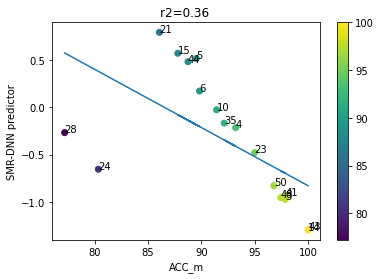

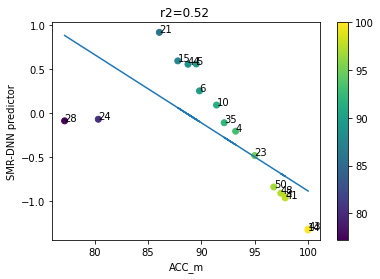

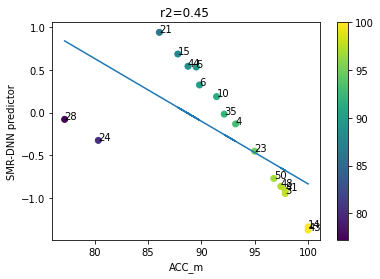

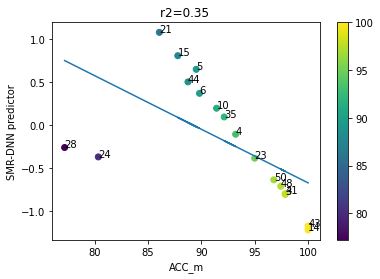

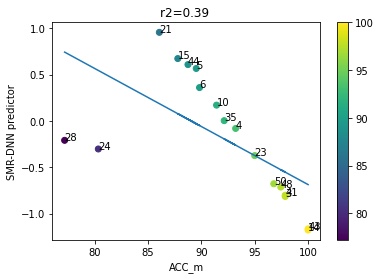

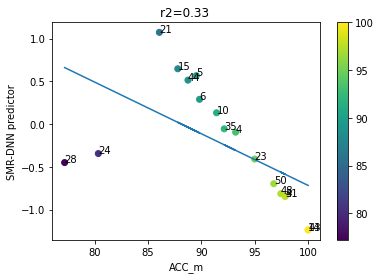

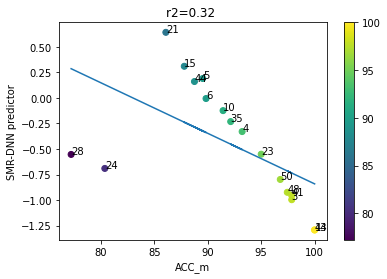

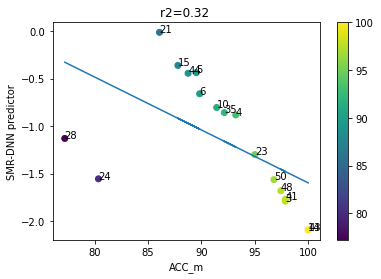

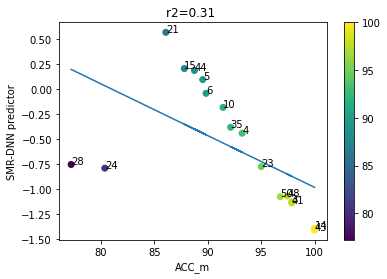

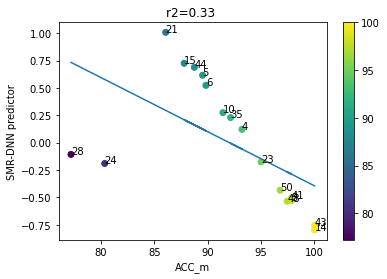

In [84]:
tf        = []
X_train   = []
model_fun = []
r_        = []
for c_h in range(0,len(Nch)):
  X_train = X_train_[c_h]
  tf = tf_[c_h]
  model_fun = model_fun2[c_h]

  ypred = model_fun.predict(X_train)
  slope, intercept, r_value, p_value, std_err = linregress(acc_m,ypred.reshape(-1))
  regr = linear_model.LinearRegression()
  regr.fit(acc_m.reshape(-1,1),ypred.reshape(-1,1))
  lrpred = regr.predict(acc_m.reshape(-1,1))
  r_.append(r_value**2)

  plt.plot(acc_m,lrpred)
  plt.scatter(acc_m,ypred,c=acc_m)
  for i in range(acc_m.shape[0]):
      plt.text(acc_m[i],ypred[i],indx[i])
  plt.xlabel('ACC_m')
  plt.ylabel('SMR-DNN predictor')
  plt.title('r2=%.2f '%r_value**2)
  plt.colorbar()
  plt.show()

In [85]:
r_

[0.3604686122487964,
 0.5193076772278833,
 0.4517655892358332,
 0.3504103994286756,
 0.3870619060626935,
 0.33350917315249506,
 0.31681347992050507,
 0.321423812610258,
 0.30544080723224654,
 0.33012234712670796]

In [ ]:
from scipy.io import savemat  # GUARDAR

dlSMR = {}
dlSMR['smr_6ch'] = ypred
dlSMR['ACC_m'] = acc_m
dlSMR['rho'] = r_value**2

#savemat('drive/My Drive/ERD_Session/DATOS GIGA/Data_R0_SMR_6.mat',dlSMR)